In [ ]:
import os
import pandas as pd
import glob
from concurrent.futures import ProcessPoolExecutor, as_completed

base_dir = "/shares/grossniklaus.botinst.uzh/dkt/projects/meth1001_code_DKT/analysis/18_jsd_temp/output"
contexts = ["CHG", "CHH", "CpG"]
temperatures = ["10C", "16C", "22C"]


def read_file(file_path, context, temp):
    try:
        with open(file_path, 'r') as f:
            for line in f:
                if line.startswith('#'):
                    header_line = line[1:].strip()  
                    columns = header_line.split('\t')  
                    break
            else:
                raise ValueError(f"No header line found in {file_path}")

        df = pd.read_csv(file_path, sep='\t', header=None, names=columns, comment='#')
        if 'Me' not in df.columns or 'Un' not in df.columns:
            raise ValueError(f"'Me' or 'Un' columns not found in {file_path}")
        df['meth'] = df['Me'] / (df['Me'] + df['Un'])
        df = df[(df['meth'] > 0) & (df['meth'] < 1)]
        if 'JSD_bit_' not in df.columns:
            print(f"'JSD_bit_' column not found in {file_path}. Adding it with NaN values.")
            df['JSD_bit_'] = None  # or np.nan if preferred
        df['context'] = context
        df['temperature'] = temp
        
        return df

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error




def process_directory(context, temp):
    dir_path = os.path.join(base_dir, f"{context}_{temp}")
    file_pattern = os.path.join(dir_path, "chr_*.txt")
    files = glob.glob(file_pattern)
    return pd.concat([read_file(file, context, temp) for file in files], ignore_index=True)

if __name__ == '__main__':
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(process_directory, context, temp) 
                   for context in contexts 
                   for temp in temperatures]
        
        all_data = []
        for future in as_completed(futures):
            all_data.append(future.result())

    combined_data = pd.concat(all_data, ignore_index=True)
    print(combined_data.head())
    combined_data.to_csv("combined_data.csv", index=False)

  chrom  start  end  JSD_bit_  sample size  HMIX_bit_   Me     Un      meth  \
0    Mt     18   18     0.014          723      0.038   54  13472  0.003992   
1    Mt     22   22     0.021          723      0.054  102  16584  0.006113   
2    Mt     23   23     0.009          723      0.030  108  35086  0.003069   
3    Mt     24   24     0.026          723      0.077  340  35691  0.009436   
4    Mt     27   27     0.018          723      0.057  248  37905  0.006500   

  context temperature  
0     CHH         22C  
1     CHH         22C  
2     CHH         22C  
3     CHH         22C  
4     CHH         22C  


/sctmp/eharpu/ipykernel_599064/2610522754.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_data = pd.read_csv("combined_data.csv")
/home/eharpu/data/conda/envs/environment_shannon/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/eharpu/data/conda/envs/environment_shannon/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

ValueError: Cannot pass values for both `x` and `y`

<Figure size 1200x800 with 0 Axes>

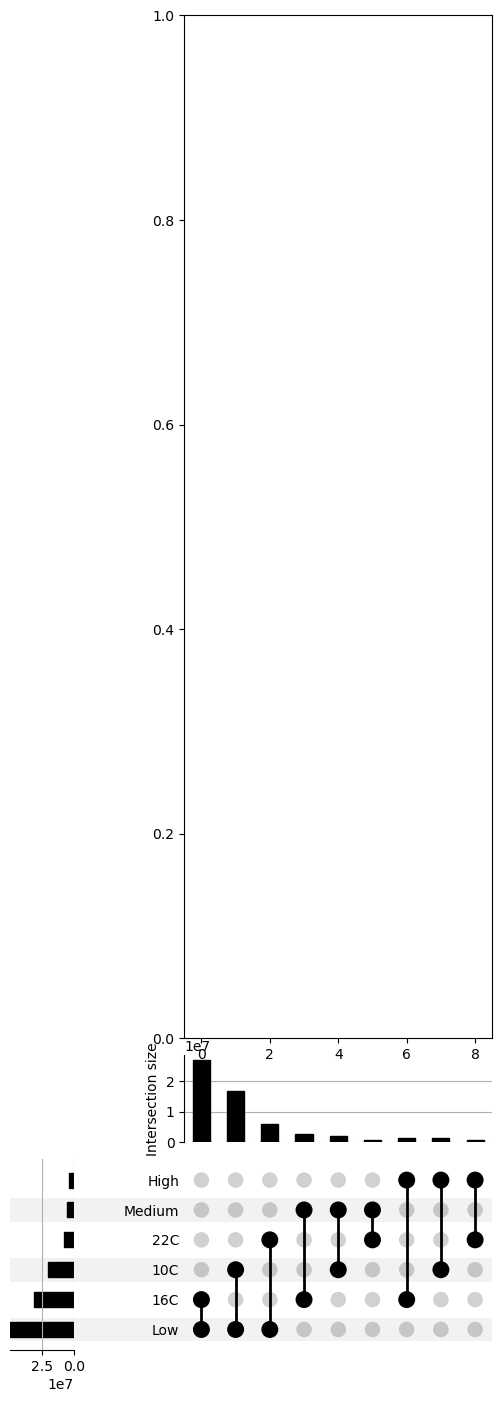

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import UpSet
from upsetplot import from_memberships
import seaborn as sns


combined_data = pd.read_csv("combined_data.csv")

# Function to categorize JSD_bit_ values
def categorize_jsd(value):
    if value < 0.2:
        return 'Low'
    elif value < 0.4:
        return 'Medium'
    else:
        return 'High'

# Add JSD category column
combined_data['JSD_category'] = combined_data['JSD_bit_'].apply(categorize_jsd)

# Create memberships
memberships = []
for _, row in combined_data.iterrows():
    memberships.append((row['temperature'], row['JSD_category']))

# Create UpSet data
upset_data = from_memberships(memberships, data=combined_data)

# Set up color palette for contexts
context_colors = sns.color_palette("viridis", n_colors=len(combined_data['context'].unique()))
color_dict = dict(zip(combined_data['context'].unique(), context_colors))

# Create the plot
fig = plt.figure(figsize=(12, 8))
upset = UpSet(upset_data, intersection_plot_elements=3, min_subset_size=10)
upset.add_catplot(value='context', kind='count', elements=30)
upset.plot()

# Modify the bar colors based on context
for container in upset.intersections.bar_container:
    for bar in container:
        context = combined_data.loc[bar.get_x():bar.get_x()+bar.get_width()]['context'].mode().values[0]
        bar.set_color(color_dict[context])

plt.title('Upset Plot: Temperature vs JSD Categories')
plt.tight_layout()
plt.show()

# plt.savefig('upset_plot.png', dpi=300, bbox_inches='tight')